# External temperature data methods for analyzing African Elephant movement with DBSCAN
### Gregory Glatzer | The Pennsylvania State University

In my analysis of the Kruger National Park dataset (**ThermochronTracking Elephants Kruger 2007**), I applied the DBSCAN clustering algorithm to identify areas and points of interest for African Elephants (Loxodonta africana). I observed that the temperature feature provided in the dataset contributed towards the movement of the elephants and the clustering patterns in their movement. This was made possible by the nature of the Kruger study, as the study focused on temperature, and therefore included this feature. 

In order to apply this clustering technique to other studies, relevant temperature data would be needed for studies that would otherwise not have a temperature feature. Unfortunately, it is not gauranteed that another study will have a temperature feature with each data point. In this notebook, I attempt to develop a technique to gather historical temperature data from weather stations near a given study, which should allow us to utilize the temperature feature in studies that did not originally have temperature as a collected feature.

## Setup

In [147]:
!pip install meteostat
!pip install requests


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point

import seaborn as sns
import matplotlib.pyplot as plt

import os
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

In [148]:
def load_movebank_data(study_name, epsg=3395):
    # Default epsg:3395 (Mercator)
    
    # Define parts of filepaths
    root_folder = r"C:\Users\grego\Anti-Poaching Research\data\Movebank"
    study_data = study_name + ".csv"
    reference_data = study_name + "-reference-data.csv"
    
    
    # build filepaths
    study_fp = os.path.join(root_folder, study_name, study_data)
    reference_fp = os.path.join(root_folder, study_name, reference_data)

    
    # load data
    study_df = pd.read_csv(study_fp)
    reference_df = pd.read_csv(reference_fp)
    
    # Create shapely Points
    study_df["geometry"] = study_df.apply(lambda row: Point([row["location-long"], row["location-lat"]]), axis=1)
    
    # Create gdf and assign CRS
    study_gdf = gpd.GeoDataFrame(study_df, geometry="geometry")
    study_gdf.crs = CRS(f"epsg:{epsg}").to_wkt()
    
    # cast timestamp to dt
    study_gdf["timestamp"] = pd.to_datetime(study_gdf["timestamp"], format="%Y-%m-%d %H:%M:%S.%f")
    
    
    return study_gdf, reference_df

### Load data

In [149]:
data, reference = load_movebank_data("ThermochronTracking Elephants Kruger 2007", epsg=22293)

In [150]:
heat = data[["timestamp", "tag-local-identifier", "location-long", "location-lat", "external-temperature"]]

# convert to datetime objects
to_datetime = pd._libs.tslibs.timestamps.Timestamp.to_pydatetime
heat.timestamp = heat.timestamp.apply(to_datetime)
heat.head()

,timestamp,tag-local-identifier,location-long,location-lat,external-temperature
0,2007-08-13 00:30:00,AM105,31.87091,-24.81373,24.0
1,2007-08-13 02:00:00,AM105,31.87399,-24.81483,23.0
2,2007-08-13 03:31:00,AM105,31.87724,-24.81673,21.0
3,2007-08-13 04:00:00,AM105,31.87822,-24.81569,21.0
4,2007-08-13 06:00:00,AM105,31.89554,-24.79870,22.0


# Gathering data from weather stations

The first step is to find some nearby weather stations to the data being collected. To do this, we will use the meteostat package to find some weather stations close to the study lat-long coords. Then, we will use meteostat's API to grab all the historical data of each station.

In [152]:
# meteostat
from meteostat import Stations

lat = heat["location-lat"].mean()
long = heat["location-long"].mean()

# Get nearby weather stations
stations = Stations()
stations_query = stations.nearby(lat, long)
stations = stations_query.fetch(10)

# Filter to stations with data at or before the earliest date in the Kruger dataset
stations = stations[stations["hourly_start"].notnull()]
min_date = heat.timestamp.min()
possible_stations = stations[stations["hourly_start"] <= min_date]
possible_stations

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
68290,Hoedspruit,ZA,LP,68290,FAHS,-24.3667,31.0333,513.0,Africa/Lusaka,1992-02-20,2021-06-21,2013-10-25,2021-06-16,NaT,NaT,66948.628138
FAMR0,Mariepskop / Angledale,ZA,MP,<NA>,FAMR,-24.5500,30.8667,1826.0,Africa/Johannesburg,1988-01-06,1988-09-13,NaT,NaT,NaT,NaT,80869.528616
68190,Phalaborwa,ZA,LP,68190,FAPH,-23.9333,31.1500,427.0,Africa/Lusaka,1958-01-01,2014-05-26,2010-10-28,2014-03-31,NaT,NaT,85528.265332
68288,Nelspruit,ZA,MP,68288,FANS,-25.4333,30.9833,671.0,Africa/Johannesburg,1998-03-01,2021-04-27,2005-02-09,2014-03-31,NaT,NaT,120693.955973
FAGV0,Gravelotte / Murchison,ZA,LP,<NA>,FAGV,-23.9000,30.6833,573.0,Africa/Johannesburg,1988-12-08,1990-07-29,NaT,NaT,NaT,NaT,122575.521519
FABN0,Barberton / Saint John’s Mission,ZA,MP,<NA>,FABN,-25.7333,31.0000,800.0,Africa/Johannesburg,1989-01-06,1991-01-17,NaT,NaT,NaT,NaT,148508.310893


Now that we have a list of possible stations to get data from, let's query the historical data from the stations. From testing, I found that some stations return no results. Also, some stations do not have a wmo (which is the identifier of the station). Because of this, we will check the result of each query, and compile the results that aren't empty into one "master" DataFrame.

In [153]:
# download station data
from meteostat import Hourly
from datetime import datetime

start = heat.timestamp.min().to_pydatetime()
end = heat.timestamp.max().to_pydatetime()

# iterate over possible stations and query stations
stations_data = []
for _, station in possible_stations.iterrows():
    wmo = station.wmo
    query = Hourly(wmo, start, end, model=False) # build query
    query = query.normalize()
    query = query.interpolate() # fill in gaps in data
    station_data = query.fetch() # the actual API call
    if station_data.shape[0] > 0:
        station_data["wmo"] = wmo
        stations_data.append(station_data)
        
stations_df = pd.concat(stations_data)
stations_df.wmo = stations_df.wmo.astype(int)

# drop null values
stations_df = stations_df[stations_df.temp.notna()]

# filter to first station (arbitrary) TODO: Make this NOT arbitrary
stations_df = stations_df[stations_df.wmo == stations_df.wmo.unique()[0]]

stations_df

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,wmo
time,,,,,,,,,,,,
2007-08-13 00:30:00,13.000,10.00,82.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,68288
2007-08-13 01:00:00,13.000,10.00,82.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,68288
2007-08-13 01:30:00,13.000,10.00,82.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,68288
2007-08-13 02:00:00,13.000,10.00,82.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,68288
2007-08-13 02:30:00,13.100,10.00,81.5,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,68288
...,...,...,...,...,...,...,...,...,...,...,...,...
2009-08-12 18:30:00,21.575,-2.15,20.5,NaN,NaN,265.0,4.6,NaN,NaN,NaN,NaN,68288
2009-08-12 19:30:00,20.750,-1.90,22.0,NaN,NaN,270.0,5.6,NaN,NaN,NaN,NaN,68288
2009-08-12 20:30:00,19.925,-1.65,23.5,NaN,NaN,275.0,6.6,NaN,NaN,NaN,NaN,68288


Now we will join the station data with the temperature data from the Kruger study, and compare the data.

In [154]:
wmo_heat = stations_df[["wmo", "temp"]]
heat_joined = pd.merge(left=heat, right=wmo_heat, left_on="timestamp", right_index=True).reset_index(drop=True)
heat_joined.rename(columns={"external-temperature": "studyTemp", "temp": "stationTemp"}, inplace=True)

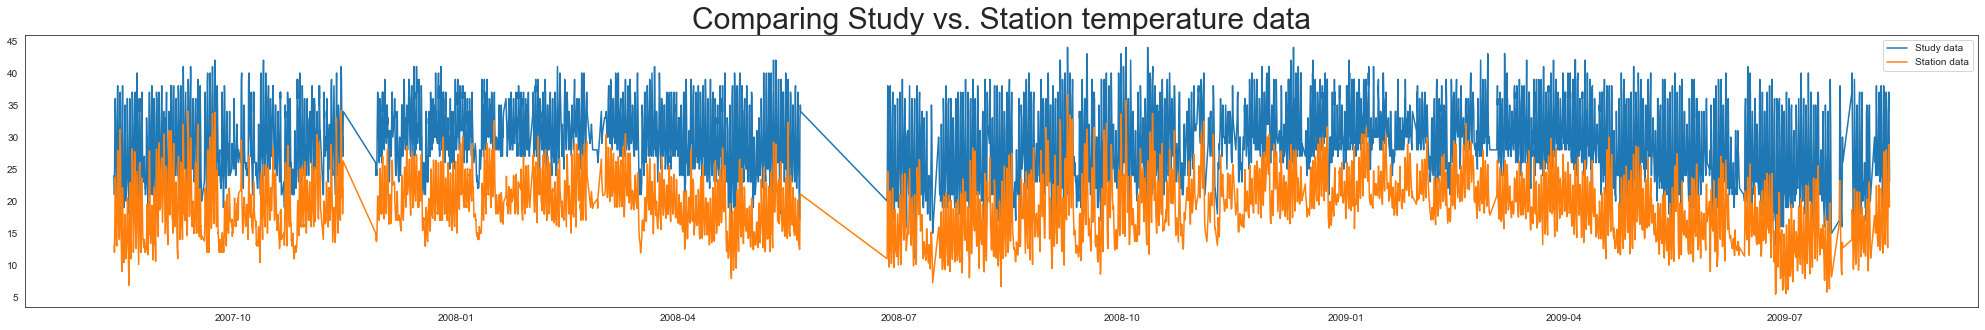

Stats
R^2:  0.6871044690549571
offset (study - station):  9.840106696689293
% of timestamps found:  61.6%


In [162]:
from sklearn.metrics import r2_score

# define subset of data on one elephant
AM105 = heat_joined[heat_joined["tag-local-identifier"] == "AM105"]

study = AM105.studyTemp
station = AM105.stationTemp

# plot it
fig, ax = plt.subplots(1,1, figsize=(35,5))

ax.plot(AM105.timestamp, study, label="Study data")
ax.plot(AM105.timestamp, station, label="Station data")

plt.title("Comparing Study vs. Station temperature data", fontsize=30)
plt.legend()
plt.show()


# statistics
offset = study.mean() - station.mean()
data_retained = AM105.stationTemp.notna().sum() / heat[heat["tag-local-identifier"] == "AM105"].shape[0] * 100
r2 = r2_score(study, station + offset) # center station with study data before calculating R^2
print("Stats")
print("R^2: ", r2)
print("offset (study - station): ", offset)
print("% of timestamps found: ", str(round(data_retained, 2)) + "%")

The station temperature data is moderately similar to the study temperature data, with an R-squared of 0.6978. 

> **If R-squared value 0.5 < r < 0.7 this value is generally considered a Moderate effect size**
>
> -- <cite>Moore, D. S., Notz, W. I, & Flinger, M. A. (2013). The basic practice of statistics (6th ed.). New York, NY: W. H. Freeman and Company. Page (138)</cite>

It is also worth noting that before calculating the R-squared, I offsetted the station data by the difference between it's average and the study's average. This is equivalent to zero-centering both datasets.

It is important to note the "% of timestamps found". This means that the weather station only matched temperature measurements for 61% of the original data (for this elephant). A possible room for improvement is to gather data from multiple weather stations in the final data.

The next step is to see how well the station data performs in DBSCAN clustering.

# Applying to DBSCAN

Before we apply the station data to DBSCAN, I want to first streamline the process described above into one reusable function.

In [163]:
def get_station_temps(elephant_data, num_stations=10):
    """
    Get historical temperature data for all data points from local weather stations.
    
    Parameters
    ------------
    elephant_data: (DataFrame) Contains at least the following columns: ["location-lat", "location-long", "timestamp"]
    
    Returns
    ------------
    heat_joined: (DataFrame) The original elephant_data with a new stationTemp column.
    closest_station: (DataFrame) Metadata describing the weather station that the temperature data came from (from the meteostat package)
    extra: (DataFrame) Some values used throughouth the calculations that may be of interest. The values are:
    
        lat: The median latitude of elephant_data, used to find the nearest weather station
        long: The median longitude of elephant_data, used to find the nearest weather station 
        start: The earliest date in elephant_data, used to narrow down the possible stations
        end: The latest date in elephant_data, used to narrow down the possible stations
        distance: The euclidean distance between the coords of the median of elephant_data, and the weather station coords.
    
    """

    lat = elephant_data["location-lat"].median() # take median to avoid outliers
    long = elephant_data["location-long"].median() # take median to avoid outliers
    start = elephant_data.timestamp.min().to_pydatetime()
    end = elephant_data.timestamp.max().to_pydatetime()
        
    # Get nearby weather stations
    stations = Stations()
    stations_query = stations.nearby(lat, long)
    stations = stations_query.fetch(num_stations)

    # Filter to stations with data in the timeframe
    stations = stations[stations["hourly_start"].notnull()]
    possible_stations = stations[(stations["hourly_start"] <= start) & (stations["hourly_end"] >= end)]
    

    # iterate over possible stations and query
    stations_data = []
    num_stations = 0
    for _, station in possible_stations.iterrows():
        wmo = station.wmo
        query = Hourly(wmo, start, end, model=False) # build query
        query = query.normalize()
        query = query.interpolate() # fill in gaps in data
        station_data = query.fetch() # the actual API call
        if station_data.shape[0] > 0:
            num_stations += 1
            station_data["wmo"] = wmo
            station_data["lat"] = station.latitude
            station_data["long"] = station.longitude
            stations_data.append(station_data)
            
    print(f"Getting data from {num_stations} stations")

    stations_df = pd.concat(stations_data)
    stations_df.wmo = stations_df.wmo.astype(int)

    # drop null values
    stations_df = stations_df[stations_df.temp.notna()]
    
    # filter to only closest station's data
    p = Point(long, lat) # point from study to find distance to
    stations_df["geometry"] = stations_df.apply(lambda row: Point(row.long, row.lat), axis=1) # add shapely point to each station
    stations_df["distance_to_study"] = stations_df.apply(lambda row: row.geometry.distance(p), axis=1)  # calculate distances
    closest_distance = stations_df.distance_to_study.min() # find closest distance
    closest_station_wmo = stations_df[stations_df.distance_to_study == closest_distance].iloc[0].wmo # get wmo of closest station
    closest_station = possible_stations[possible_stations.wmo == str(closest_station_wmo)].iloc[0] # get station information
    
    print(f"Using station data from Station(wmo = {closest_station.wmo})")
    # make sure types are the same so they can be compared
    stations_df.wmo = stations_df.wmo.astype(int)
    closest_station.wmo = int(closest_station.wmo)
    stations_df = stations_df[stations_df.wmo == closest_station.wmo] # filter to only this station's data
    
    
    wmo_heat = stations_df[["temp"]]
    heat_joined = pd.merge(left=elephant_data, right=wmo_heat, left_on="timestamp", right_index=True, how="left").reset_index(drop=True)
    heat_joined.rename(columns={"temp": "stationTemp"}, inplace=True)
    
    # return some info about the calculations
    extra = {"lat": lat, "long": long, "start": start, "end": end, "distance": closest_distance}
    
    return heat_joined, closest_station, pd.DataFrame(extra, index=[0])

The next block of code is copied from the Kruger ML notebook. It is all of the DBSCAN code and related helper code. There are some changes and additions to account for the temperature workflow.

In [164]:
def perform_DBSCAN(data, radius, min_points, noise, cols):

    subset = data[cols]
    scaled = StandardScaler().fit_transform(subset)

    # perform DBSCAN 
    db = DBSCAN(eps=radius, min_samples=min_points).fit(scaled)
    
    # add cluster labels
    labels = db.labels_
    data["cluster"] = labels
    
    if not noise:
        return data[data["cluster"] != -1]

    return data
    

def get_clusters(data, cols, r = 0.2, mp = 50, noise=False):
    """
    calls perform_DBSCAN and calculates centroids
    noise: return the datapoints that are not in any clusters (aka noise)
    """

    # Apply DBSCAN
    clusters = perform_DBSCAN(data, 
                              radius=r, 
                              min_points=mp,
                              noise=noise,
                              cols=cols
                             )

    # calculate centroids
    centroids = clusters.groupby("cluster")[cols].apply(np.mean)
    centroids["geometry"] = centroids.apply(lambda row: Point([row["location-long"], row["location-lat"]]), axis=1)

    
    return clusters, centroids


def with_and_without_heat(data, 
                          heat_col="stationTemp",
                          noise=True,
                          r_heat=0.2, mp_heat=50, r_wo=0.1, mp_wo=35):
    
    clusters_heat, centroids_heat, clusters_wo, centroids_wo = None, None, None, None
    
    # some data points' temp will be NaN if it couldn't be found by in station data. Drop these rows.
    data_with_temps = data[data[heat_col].notna()]
    print(f"Calculating temp-influenced clusters and centroids {data_with_temps.shape}")

    clusters_heat, centroids_heat = get_clusters(data_with_temps, 
                                           ["location-long", "location-lat", heat_col],
                                           r=r_heat, mp=mp_heat, 
                                           noise=noise
                                          )
    centroids_heat["feature space"] = "Temp-influenced"


    print(f"Calculating without-temp clusters and centroids {data.shape}")
    # use all data, regardless of missing temp to calculate exclusively coordinate-based clustering
    clusters_wo, centroids_wo = get_clusters(data, 
                                           ["location-long", "location-lat"],
                                           r=r_wo, mp=mp_wo, 
                                           noise=noise
                                          )
    centroids_wo["feature space"] = "Without temp-influence"
        
    
    return [(clusters_heat, centroids_heat), (clusters_wo, centroids_wo)]


def plot_centroids(centroids, ax, hue="cluster"):
    
    centroids_heat = centroids[centroids["feature space"] == "Temp-influenced"]
    sns.scatterplot(data = centroids_heat, 
                        x="location-long", 
                        y="location-lat",
                        color="black",
                        palette="Paired",
                        marker="X",
                        s=85,
                        legend=False,
                        ax=ax
                       )
    
    # I am aware that the style attribute won't be used since I split up the data.
    # It is solely to render the legend for the different marker shapes
    centroids_wo = centroids[centroids["feature space"] == "Without temp-influence"]
    sns.scatterplot(data = centroids_wo, 
                        x="location-long", 
                        y="location-lat",
                        hue=hue,
                        palette="Paired",
                        style="feature space",
                        style_order=["Without temp-influence", "Temp-influenced"],
                        s=75,
                        edgecolor='black',
                        linewidth=.8,
                        ax=ax
                       )


def plot_range(clusters, centroids, ax=None, show=True):
    """
    plots clusters and centroids for ONE elephant
    """
    
    # plot clusters
    if ax == None:
        fig, ax = plt.subplots(1, figsize=(10,10))
    
    sns.set_style("white")
    sns.despine()
    sns.scatterplot(data = clusters, 
                    x="location-long", 
                    y="location-lat",
                    hue="cluster",
                    palette="Paired",
                    legend=False,
                    s=4,
                    ax=ax
                   )
    
    plot_centroids(centroids, ax)
    

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Legend")
    
    if show:
        plt.show()
    else: 
        return ax

Let's test out how well the temperature data from the weather stations works with the DBSCAN clustering algorithm on elephant AM105 from the Kruger dataset.

Getting data from 4 stations
Using station data from Station(wmo = 68288)
% of timestamps matched:  61.598
Calculating temp-influenced clusters and centroids (15098, 12)
Calculating without-temp clusters and centroids (15098, 12)


No handles with labels found to put in legend.


Calculating temp-influenced clusters and centroids (9300, 13)
Calculating without-temp clusters and centroids (15098, 13)


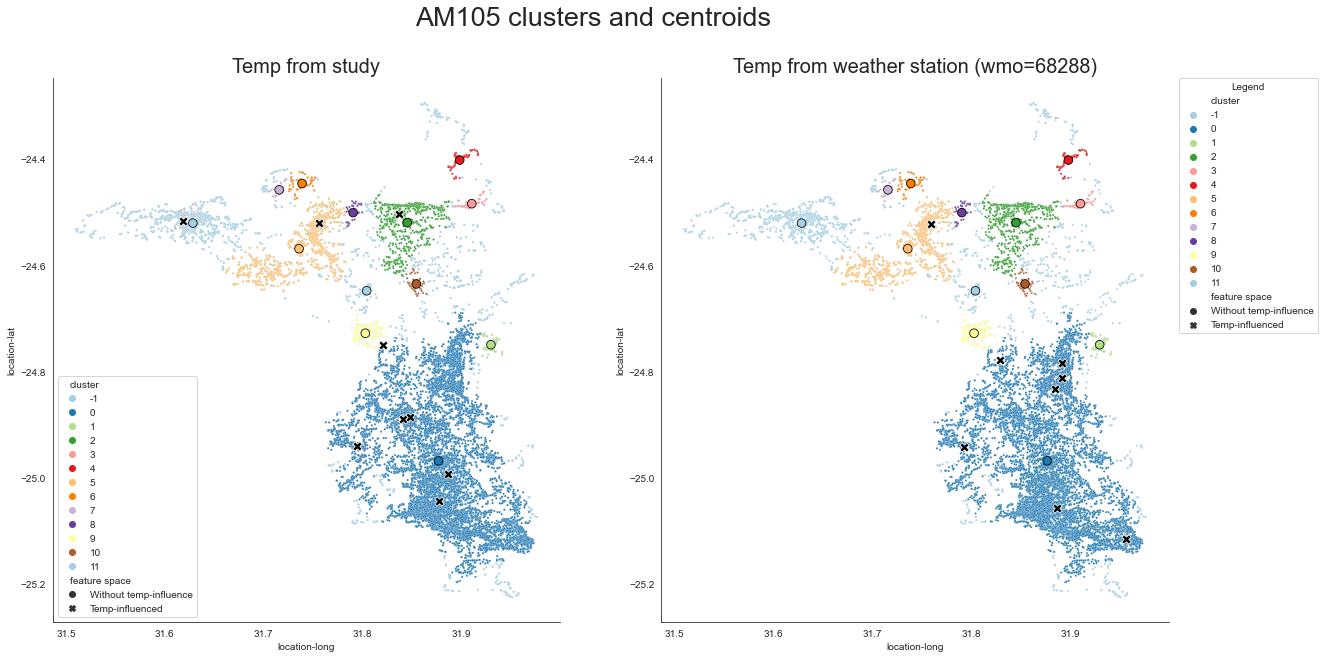

In [165]:
%matplotlib inline

tag = "AM105"
elephant_data = data[data["tag-local-identifier"] == tag]


# get station data
station_data, station, extra = get_station_temps(elephant_data)


# rename columns so plotting works
column_mapping = {"external-temperature": "studyTemp", "stationTemp": "external-temperature"}
station_data = station_data.rename(columns=column_mapping)


# calculate percent of timestamps we found temp data for
percent_found = station_data[station_data["external-temperature"].notna()].shape[0] / elephant_data.shape[0] * 100
print("% of timestamps matched: ", round(percent_found, 3))


# calculate and plot clusters and centroids
fig, axs = plt.subplots(1,2, figsize=(20,10))

for i, df in enumerate([elephant_data, station_data]):

    (clusters_heat, centroids_heat), (clusters_wo, centroids_wo) = with_and_without_heat(df, 
                                                                                         heat_col="external-temperature",
                                                                                         r_heat=0.2, mp_heat=50, 
                                                                                         r_wo=0.1, mp_wo=35)
    clusters = clusters_heat.append(clusters_wo)
    centroids = centroids_heat.append(centroids_wo)

    plot_range(clusters, centroids, ax=axs[i], show=False)

fig.suptitle(f"{tag} clusters and centroids", fontsize=27)
axs[0].set_title("Temp from study", fontsize=20)
axs[1].set_title(f"Temp from weather station (wmo={station.wmo})", fontsize=20)
plt.show()


On the left is the results of clustering using heat data provided by the study, where the right shows centroids (marked with an X) calculated using heat data from weather stations. Both systems find clusters that make sense, and the centroids found with the weather station data is comparable to the original centroids found. This shows that this technique can be applied to other datasets that have no temperatures to begin with. 

The major pitfall, however, is the loss of data. For this elephant's data, for instance, we were only able to find temperatures for 61.6% of the data points. This may be a source of why the centroids are in different locations, as there are less data points, and thus the clustering may be different.

# Extending to other datasets

We are going to extend this technique to the dataset from  study **African elephants in Etosha National Park (data from Tsalyuk et al. 2018)**. Unfortunately, an extreme amount of the data is lost (94%) when running the algorithm on this dataset, as many timestamps are not matched. Because of this, we will run it on the entire dataset instead of a single elephant to give us more data to work with.

In [166]:
etosha_data, reference = load_movebank_data("African elephants in Etosha National Park (data from Tsalyuk et al. 2018)")
etosha_data.head()

,event-id,visible,timestamp,location-long,location-lat,sensor-type,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,geometry
0,7980499272,True,2008-10-30 00:15:00,16.202088,-19.063725,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...,POINT (16.20209 -19.06372)
1,7980499273,True,2008-10-30 02:46:00,16.209496,-19.069908,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...,POINT (16.20950 -19.06991)
2,7980499274,True,2008-10-30 03:31:00,16.214184,-19.068719,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...,POINT (16.21418 -19.06872)
3,7980499275,True,2008-10-30 03:45:00,16.214170,-19.068683,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...,POINT (16.21417 -19.06868)
4,7980499276,True,2008-10-30 05:31:00,16.229372,-19.058258,gps,Loxodonta africana,AG005,LA5,African elephants in Etosha National Park (dat...,POINT (16.22937 -19.05826)


In [1]:
e_elephant_data = etosha_data

# get station data
e_station_data, e_station, e_extra = get_station_temps(e_elephant_data)

# calculate percent of timestamps we found temp data for
percent_found = e_station_data[e_station_data["stationTemp"].notna()].shape[0] / e_elephant_data.shape[0] * 100
print("Timestamps found: ", str(round(percent_found, 3)) + "%") 

# calculate and plot clusters and centroids
fig, ax = plt.subplots(1,1, figsize=(10,10))
                                                                        # r_heat=0.2, mp_heat=50, r_wo=0.1, mp_wo=35
(clusters_heat, centroids_heat), (clusters_wo, centroids_wo) = with_and_without_heat(e_station_data,
                                                                                     r_heat=0.2, mp_heat=25, 
                                                                                     r_wo=0.05, mp_wo=37
                                                                                     )
clusters = clusters_heat.append(clusters_wo)
centroids = centroids_heat.append(centroids_wo)

ax.set_title(f"Etosha National Park with interpolated heat data (wmo={e_station.wmo})", fontsize=18)
plot_range(clusters, centroids, ax=ax)

plt.show()

NameError: name 'etosha_data' is not defined

I am very impressed by the performance on this dataset. Even though meteostat could only match a little more than 6% of the data points to a temperature reading from a weather station, the centroids calculated still make sense. I believe what explains this is that even in an extremely small sample of the data, the clusters will still exist. By the definition of clustering (more data in that location), the small sample will still have more data points in that area for DBSCAN to flag as a cluster.

Another important observation is the parameters used. For the DBSCAN without temperature, I used r_wo=0.05, mp_wo=37 (wo stands for _without temperature_), whereas the temp-influenced centroids were calculated using r_heat=0.2, mp_heat=25. What was interesting was how small the radius (epsilon) was for the wo DBSCAN. perhaps this is because of the high density of some areas, versus a dataset that has a lower density maximum.

Finally, I want to test out the system on a dataset that is different in nature. The movement in the dataset **Elliptical Time-Density Model (Wall et al. 2014) African Elephant Dataset (Source-Save the Elephants)** has different movement patterns. Before we perform clustering, let's look at the data to understand what is different.

In [169]:
f_data, f_reference = load_movebank_data('Elliptical Time-Density Model (Wall et al. 2014) African Elephant Dataset (Source-Save the Elephants)')

# remove NaNs
f_data = f_data[f_data["location-lat"].notna()]
f_data = f_data[f_data["location-long"].notna()]
f_data = f_data[f_data["timestamp"].notna()]

f_data = f_data[f_data["location-long"] < 30] # remove some outliers

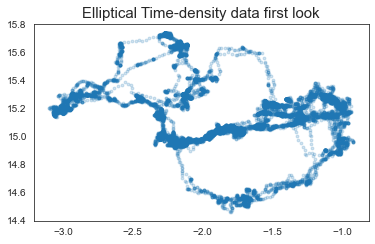

In [170]:
ax = f_data.plot(markersize=8, alpha=0.2)
ax.set_title("Elliptical Time-density data first look", fontsize=15)
plt.show()

This data has a lot more obvious trails and less obvious large clusters. Let's see how the clustering algorithm works with heat data provided by a weather station.

Getting data from 10 stations
Using station data from Station(wmo = 61240)
Timestamps found:  92.204%
Calculating temp-influenced clusters and centroids (20259, 19)
Calculating without-temp clusters and centroids (21972, 19)


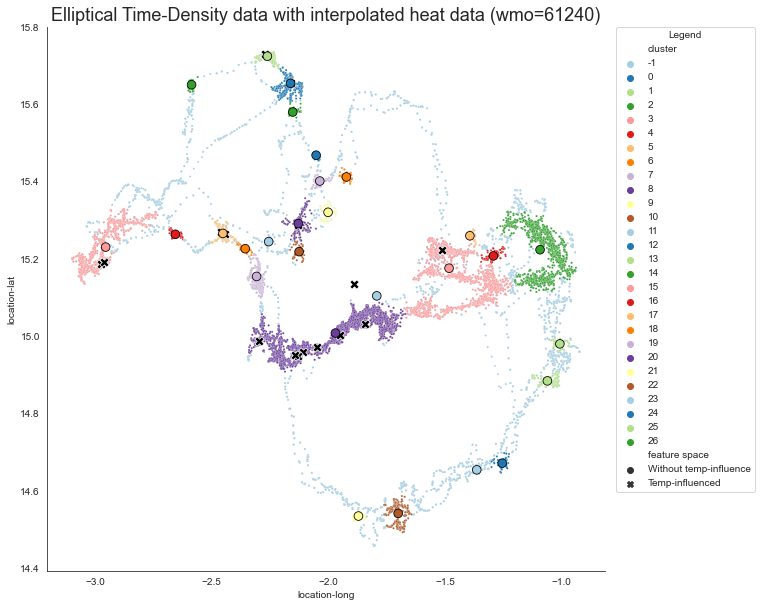

In [173]:
# get station data
f_station_data, f_station, f_extra = get_station_temps(f_data)

# calculate percent of timestamps we found temp data for
percent_found = f_station_data[f_station_data["stationTemp"].notna()].shape[0] / f_data.shape[0] * 100
print("Timestamps found: ", str(round(percent_found, 3)) + "%") 

# calculate and plot clusters and centroids
fig, ax = plt.subplots(1,1, figsize=(10,10))
                                                                        # r_heat=0.2, mp_heat=50, r_wo=0.1, mp_wo=35
(clusters_heat, centroids_heat), (clusters_wo, centroids_wo) = with_and_without_heat(f_station_data,
                                                                                     r_heat=0.1, mp_heat=35, 
                                                                                     r_wo=0.06, mp_wo=45
                                                                                     )
clusters = clusters_heat.append(clusters_wo)
centroids = centroids_heat.append(centroids_wo)

ax.set_title(f"Elliptical Time-Density data with interpolated heat data (wmo={f_station.wmo})", fontsize=18)
plot_range(clusters, centroids, ax=ax)

plt.show()

The clustering algorithm identified clusters that make sense, and marked the paths between them as noise (-1). The heat data, however, did not provide much insight. This example illustrates that although the algorithm works on many datasets, temperature data is not always too useful.

# Conclusion

Performing spatial clustering on elephant data may be helpful in identifying important locations for elephants. In this notebook, I applied DBSCAN onto elephant data from 3 studies: **ThermochronTracking Elephants Kruger 2007**, **African elephants in Etosha National Park (data from Tsalyuk et al. 2018)**, and **Elliptical Time-Density Model (Wall et al. 2014) African Elephant Dataset (Source-Save the Elephants)**. All of this data is publicly available from the [Movebank Data Repository](https://www.datarepository.movebank.org/). We saw how DBSCAN can be used to identify clusters in these datasets, and how different parameters for epsilon (r in this notebook), and min_samples (mp in this notebook) can affect the results.

In addition to a basic application of DBSCAN onto a spatial dataset, I also added temperature data from an external source (meteostat hourly weather station API). I developed a system that attempts to match temperature data with any dataset with latitude, longitude, and timestamp for each data point. With varying degrees of success (due to data loss), we were able to match temperature readings from weather stations to timestamps in an otherwise temperature-less dataset. This allowed us to utilize temperature as another feature to help explain the clustering of elephant movement.

Further work may include applying this technique to animal movement other than the African Elephant (Loxodonta africana). Datasets such as **Movement syndromes across vertebrate taxa (data from Abrahms et al. 2017)** may allow this analysis. Additionally, methods to prevent the loss of data seen above should be further pursued. This could be combining data from multiple weather stations, generalizing timestamps, or finding other sources of temperature readings.